<a href="https://colab.research.google.com/github/zhipiguozi/fast-rcnn/blob/master/%E2%80%9Cdemo_refactored_dianping_classification_with_BERT_fastai_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.text import *

In [2]:
!wget https://github.com/wshuyi/public_datasets/raw/master/dianping.csv

--2020-04-26 13:00:03--  https://github.com/wshuyi/public_datasets/raw/master/dianping.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wshuyi/public_datasets/master/dianping.csv [following]
--2020-04-26 13:00:03--  https://raw.githubusercontent.com/wshuyi/public_datasets/master/dianping.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 531037 (519K) [text/plain]
Saving to: ‘dianping.csv.1’

dianping.csv.1      100%[===================>] 518.59K  --.-KB/s    in 0.003s  

2020-04-26 13:00:03 (161 MB/s) - ‘dianping.csv.1’ saved [531037/531037]



In [0]:
df = pd.read_csv("dianping.csv")

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train, test = train_test_split(df, test_size=.2, random_state=2)

In [0]:
train, valid = train_test_split(train, test_size=.2, random_state=2)

In [7]:
len(train)

1280

In [8]:
len(valid)

320

In [9]:
len(test)

400

In [10]:
train.head()

,comment,sentiment
330,跟老公去大悦城玩儿的时候吃的，味道真的还不错哦！这家店是一对年轻的小两口自主创业开的店，环境...,1
1326,味道是好，但是真的很生气，排了两个小时的队伍就为了吃干酪鱼，进来被告知没有了，我觉得起码没有...,0
666,还好吧，调调不错，排队人多。。,1
1753,星期一人依旧是那么多，五点刚过就到了，基本上坐满了。菜品种类不少，这次赶上了青口贝挺好的。烤...,1
1885,4点半进去没等座。大拉皮好实惠。麻酱别都放否则太甜。薰骨肉香味浓。家常茄子精工细做，很好。还...,1


In [11]:
!pip install pytorch-transformers

In [0]:
from pytorch_transformers import BertTokenizer, BertForSequenceClassification

In [0]:
bert_model = "bert-base-chinese"
max_seq_len = 128
batch_size = 32

In [0]:
bert_tokenizer = BertTokenizer.from_pretrained(bert_model)

In [15]:
list(bert_tokenizer.vocab.items())[2000:2005]

[('姗', 2000), ('姚', 2001), ('姜', 2002), ('姝', 2003), ('姣', 2004)]

In [0]:
bert_vocab = Vocab(list(bert_tokenizer.vocab.keys()))

In [0]:
class BertFastaiTokenizer(BaseTokenizer):
    def __init__(self, tokenizer, max_seq_len=128, **kwargs):
        self.pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t):
        return ["[CLS]"] + self.pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [0]:
tok_func = BertFastaiTokenizer(bert_tokenizer, max_seq_len=max_seq_len)

In [0]:
bert_fastai_tokenizer = Tokenizer(
    tok_func=tok_func,
    pre_rules = [],
    post_rules = []
)

In [0]:
path = Path(".")

In [21]:
databunch = TextClasDataBunch.from_df(path, train, valid, test,
                  tokenizer=bert_fastai_tokenizer,
                  vocab=bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment",
                  label_cols='sentiment',
                  bs=batch_size,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

In [22]:
databunch.show_batch()

text,target
[CLS] 好 久 没 来 娜 娜 家 了 ， 之 前 还 是 几 年 前 在 风 荷 园 那 家 店 吃 的 感 觉 不 错 ， 可 能 期 待 值 过 高 了 。 服 务 还 是 不 错 的 都 是 年 轻 人 响 应 速 度 蛮 快 的 。 环 境 嘈 杂 ， 很 乱 。 可 能,0
[CLS] 首 先 ， 点 的 招 牌 凉 皮 ， 碳 烤 [UNK] 子 和 馅 饼 。 凉 皮 吃 到 了 嘎 嘣 嘎 嘣 的 口 感 的 ， 不 晓 得 是 没 有 熟 还 是 熟 过 头 ， 味 道 一 般 ， 我 自 己 在 家 醋 加 麻 酱 加 香 油 也 能 做 出 来 ， 无,0
[CLS] 保 证 下 次 不 会 再 来 了 ， 说 说 问 题 吧 。 先 说 排 队 人 太 多 ， 饭 店 火 可 以 理 解 ， 前 面 有 11 桌 居 然 等 了 一 小 时 ， 没 有 给 客 户 准 备 茶 水 和 零 食 而 且 告 诉 过 号 需 要 重 排 ， 难,0
[CLS] 真 不 知 道 怎 么 那 么 火 的 ， 排 队 感 受 一 次 ， 绝 对 一 次 再 也 不 会 去 了 。 慢 ， 排 队 慢 、 点 餐 慢 、 上 菜 慢 、 叫 服 务 员 慢 、 拿 东 西 慢 。 结 账 站 在 你 眼 前 死 盯 ， 也 不 管 你 是,0
[CLS] 这 次 口 味 只 给 三 星 ， 熏 排 骨 一 如 既 往 的 好 ， 虾 仁 真 是 败 笔 ， 外 面 裹 的 蛋 液 把 虾 的 鲜 香 完 全 盖 住 ， 全 是 蛋 的 腥 味 ， 绝 对 不 会 在 点 ！ 羊 排 价 格 不 算 便 宜 ， 很 期 待 ，,1


In [0]:
class MyNoTupleModel(BertForSequenceClassification):
  def forward(self, *args, **kwargs):
    return super().forward(*args, **kwargs)[0]

In [0]:
bert_pretrained_model = MyNoTupleModel.from_pretrained(bert_model, num_labels=2)

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
learn = Learner(databunch, 
                bert_pretrained_model,
                loss_func=loss_func,
                metrics=accuracy)

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


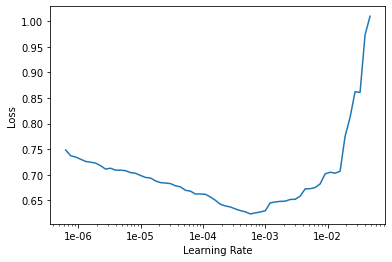

In [28]:
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(2, 2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.506221,0.332198,0.868750,00:21
1,0.345072,0.289046,0.884375,00:21


In [0]:
def dumb_series_prediction(n):
  preds = []
  for loc in range(n):
    preds.append(int(learn.predict(test.iloc[loc]['comment'])[1]))
  return preds

In [0]:
preds = dumb_series_prediction(len(test))

In [32]:
preds[:10]

[1, 1, 1, 1, 1, 0, 1, 1, 0, 1]

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
print(classification_report(test.sentiment, preds))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       203
           1       0.86      0.91      0.88       197

    accuracy                           0.88       400
   macro avg       0.88      0.88      0.88       400
weighted avg       0.88      0.88      0.88       400



In [35]:
print(confusion_matrix(test.sentiment, preds))

[[173  30]
 [ 17 180]]


In [36]:
learn.predict('这家菜非常好吃')

(Category 1, tensor(1), tensor([0.0645, 0.9355]))

In [37]:
learn.predict('这家菜很难吃')

(Category 0, tensor(0), tensor([0.8723, 0.1277]))

# 新段落

In [0]:
learn.export()

In [46]:
lear=load_learner(path)

In [47]:
lear.predict('好吃')

(Category 1, tensor(1), tensor([0.1261, 0.8739]))